# Evaluate Overview

This tutorial provides an overview of the in-built functionalities to evaluate the learned embeddings for downstream machine learning tasks leveraging metadata information. 

Evaluation is designed as additional pipeline step after `.run()` (which includes preprocessing, training, predict on test data and visualization).

When you work with a pre-trained model, make sure that you perform the `.predict()` step such that embeddings are calculated for newly provided test-samples. 

## Stackix example

We will use a Stackix as an example to show options in embedding evaluation. 

In [1]:
# Train the Stackix similar to pipeline tutorial
import autoencodix as acx
from autoencodix.configs.default_config import DataCase
from autoencodix.configs.stackix_config import StackixConfig
from autoencodix.utils.example_data import EXAMPLE_MULTI_BULK

# Stackix has its own config class
# instead of passing a pandas DataFrame, we use a pre-defined DataPackage object directly.
# this time with single cell data
print("Input data:")
print(EXAMPLE_MULTI_BULK)
print("-" * 50)
my_config = StackixConfig(
    epochs=100,
    checkpoint_interval=5,
    default_vae_loss="kl",  
    data_case=DataCase.MULTI_BULK,
)
print("\n")
print("Starting Pipeline")
print("-" * 50)
print("-" * 50)
stackix = acx.Stackix(data=EXAMPLE_MULTI_BULK, config=my_config)
result = stackix.run()


Input data:
multi_bulk:
  transcriptomics: 500 samples × 100 features
  proteomics: 500 samples × 80 features
annotation:
  transcriptomics: 500 samples × 3 features
  proteomics: 500 samples × 3 features
--------------------------------------------------


Starting Pipeline
--------------------------------------------------
--------------------------------------------------
in handle_direct_user_data with data: <class 'autoencodix.data.datapackage.DataPackage'>
anno key: transcriptomics
anno key: proteomics
Training each modality model...
Training modality: transcriptomics
Training modality: transcriptomics
Epoch 1 - Train Loss: 15.6898
Sub-losses: recon_loss: 15.6898, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 1 - Valid Loss: 11.6167
Sub-losses: recon_loss: 11.6167, var_loss: 0.0000, anneal_factor: 0.0000, effective_beta_factor: 0.0000
Epoch 2 - Train Loss: 14.9519
Sub-losses: recon_loss: 14.9519, var_loss: 0.0000, anneal_factor: 0.0001, effective_be

Before we perform embedding evaluation on a metadata parameter. Let's check visually if latent space shows discrimination regarding this parameter.

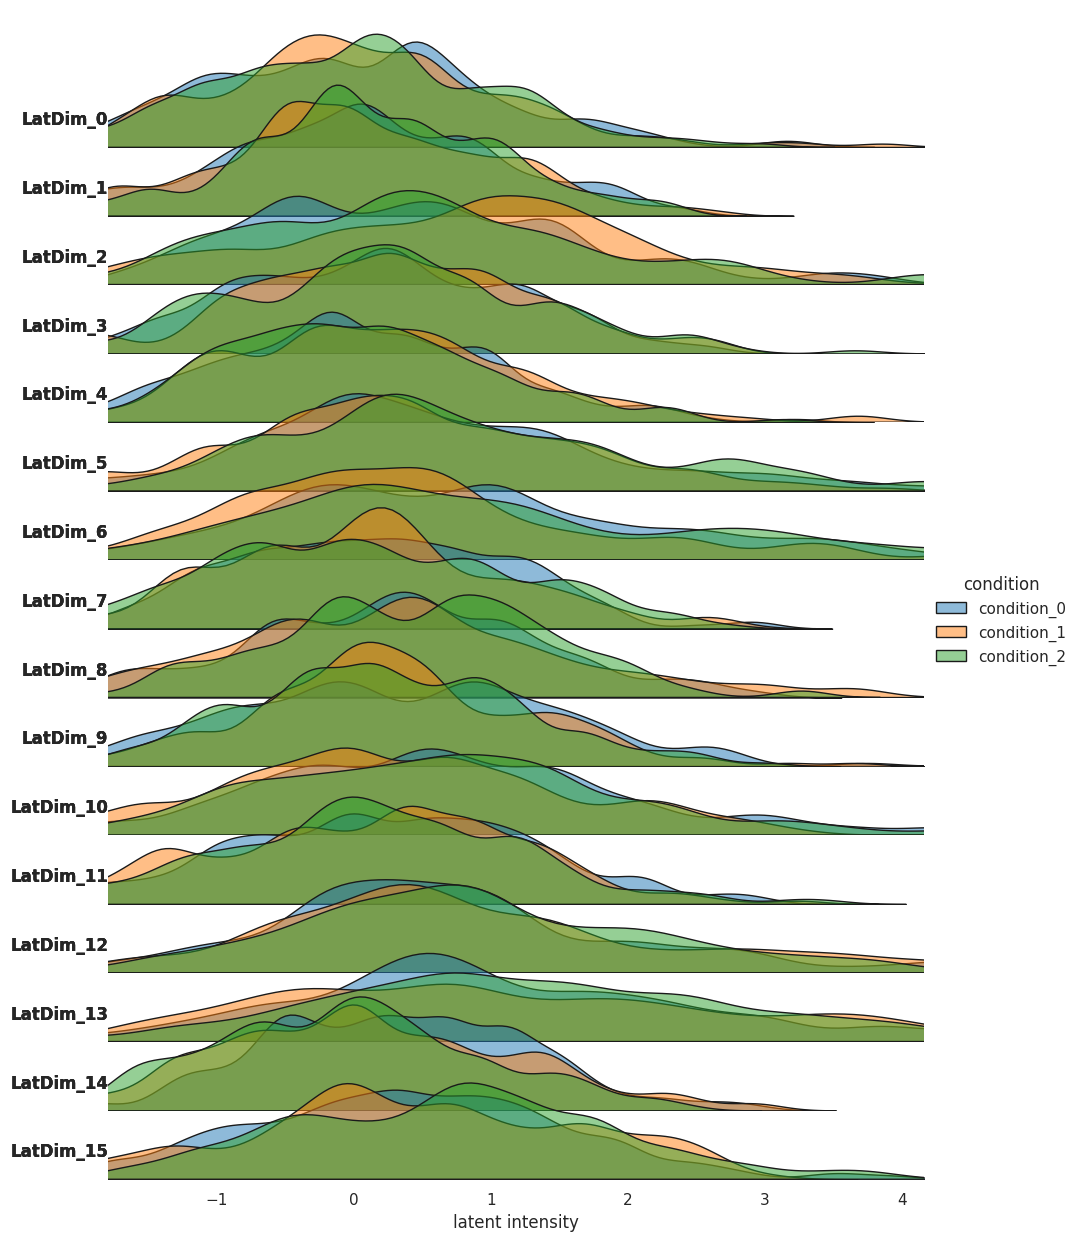

In [17]:
my_target_param = "condition"  

stackix.visualizer.show_latent_space(
	result= result,
	plot_type="Ridgeline",
	param= [my_target_param]
)

We can see a separation of conditions along several dimension. Hence, we can expect that embeddings are useful to classify. 

TODO make example stackix better

Now we can call the pipeline step `stackix.evaluate()`

In [20]:
result = stackix.evaluate(params=[my_target_param])

print("Evaluation results:")
print(result.embedding_evaluation)

Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: condition
Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: condition
Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: condition
Evaluation results:
  score_split CLINIC_PARAM       metric    value                ML_ALG  \
0       train    condition  roc_auc_ovo  0.63456  LogisticRegression()   
1       valid    condition  roc_auc_ovo  0.57284  LogisticRegression()   
2        test    condition  roc_auc_ovo  0.56256  LogisticRegression()   
0       train    condition  roc_auc_ovo  0.63456  LogisticRegression()   
1       valid    condition  roc_auc_ovo  0.57284  LogisticRegression()   
2        test    condition  roc_auc_ovo  0.56256  LogisticRegression()   
0       train    condition  roc_auc_ovo  0.63456  LogisticRegression()   
1       valid    condition  roc_auc_ovo  0.57284  LogisticRegression()   
2        test    condition  r

From the dataframe containing the results, we can see that default configuration of `.evaluate()` uses linear machine learning models for regression and classification tasks. 

But evaluate offers many options for a detailed inspection: 
- With `ml_model_class` and `ml_model_regression` user can provide any machine learning method if they are using a sklearn-like interface. 
- `params` - Is the list of metadata parameter on which downstream tasks will be performed. If not a list, but the string "all" is provided, all parameters will be evaluated. Type of task classification vs. regression will be auto-detected. Make sure to avoid providing class information as integers or floats.
- With `metric_class` and `metric_regression` the metric for evaluation is specified for classification (Default: `roc_auc_ovo`) or regression (Default: `r2`). Must be one as described in sklearn: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-string-names 
- `split_type` - Specifies how data should be splitted for training and testing downstream ML models. Default is `use-split` which will use established split and will train on the train split. Alternatively and in case there is no train split, cross-validation can be performed by using a string like "LOOCV", "CV-5", ... "CV-10", where the number specifies the number of folds. 
- `n_downsample` - To speed up evaluation on large data sets, evaluation can be performed on a random subset. Default is 10000. You may need to increase in case of extreme class-imbalance.
- `reference_methods` - For cross-refence of embedding performance you can check (provided as list):
	- "RandomFeature" will pick randomly pick input features in the same number as `latent_dim` and provides a lower performance baseline. Will be repeated five times.
	- "PCA", "UMAP" or "TSNE" will perform dimension reduction to `latent_dim` to compare autoencoder embeddings to other techniques.

Let's check this with an advanced example:

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)  # Use a custom classifier from sklearn including hyperparameters
metric_class = "accuracy"  # Choose another metric to evaluate classification performance
split_type = "CV-5" # Use 5-fold cross-validation instead of the predefined train/test split
reference_methods = ["RandomFeature", "PCA"]  # Compare results to additional reference methods

result = stackix.evaluate(
	params=[my_target_param],
    ml_model_class=rf,
    metric_class=metric_class,
    split_type=split_type,
    reference_methods=reference_methods
)

Perform ML task with feature df: RandomFeature
RandomFeature_R1
RandomFeature_R2
RandomFeature_R3
RandomFeature_R4
RandomFeature_R5
Perform ML task with feature df: PCA
PCA
Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: condition


Note, that evaluation results will be updated with additional evaluate calls:

In [22]:
print("Evaluation results:")
print(result.embedding_evaluation)

Evaluation results:
   score_split CLINIC_PARAM       metric    value                    ML_ALG  \
0        train    condition  roc_auc_ovo  0.63456      LogisticRegression()   
1        valid    condition  roc_auc_ovo  0.57284      LogisticRegression()   
2         test    condition  roc_auc_ovo  0.56256      LogisticRegression()   
0        train    condition  roc_auc_ovo  0.63456      LogisticRegression()   
1        valid    condition  roc_auc_ovo  0.57284      LogisticRegression()   
..         ...          ...          ...      ...                       ...   
5        train    condition     accuracy  1.00000  RandomForestClassifier()   
6        train    condition     accuracy  1.00000  RandomForestClassifier()   
7        train    condition     accuracy  1.00000  RandomForestClassifier()   
8        train    condition     accuracy  1.00000  RandomForestClassifier()   
9        train    condition     accuracy  1.00000  RandomForestClassifier()   

           ML_TYPE ML_TASK ML_S

Results can be visualized as bar plots:

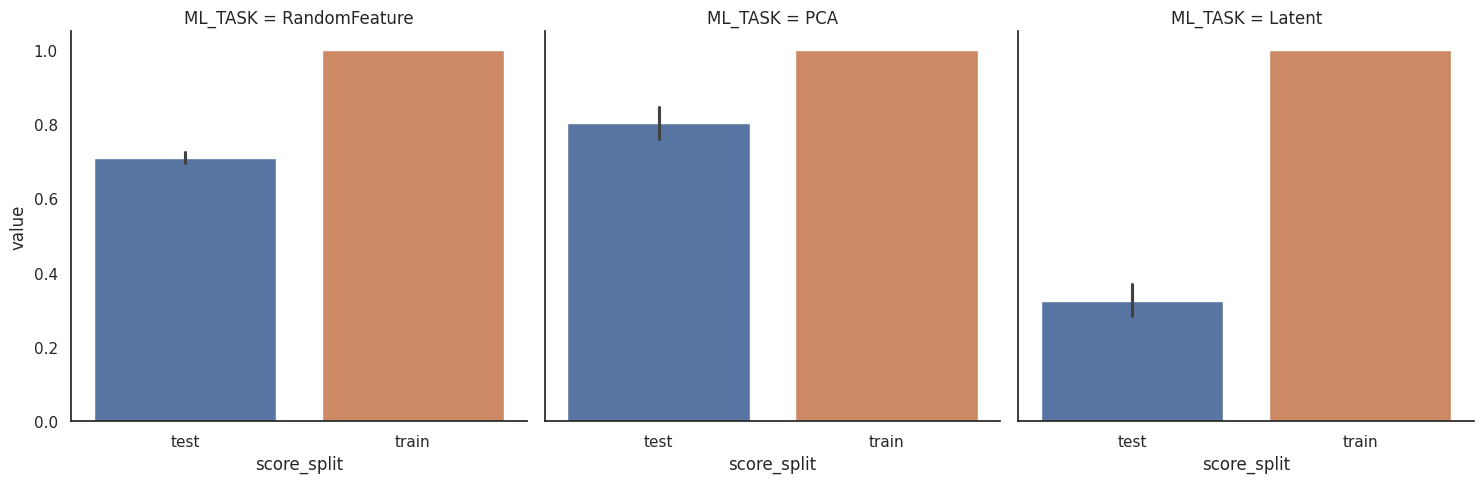

In [24]:
fig_condition_eval_linear = stackix.visualizer.show_evaluation(
	param=my_target_param, # The parameter to visualize
	metric="accuracy", # The metric we specified
	ml_alg=str(rf) # The string representation of the classifier used
)

## Using evaluate with non-sklearn models
We can use other machine learning models which are not from sklearn, but have the same interface. 
An recent and powerful example is the foundation model TabPFN https://github.com/PriorLabs/TabPFN

In [27]:
## Variable needs to set otherwise an error occurs when importing scipy
%env SCIPY_ARRAY_API=1

env: SCIPY_ARRAY_API=1


In [28]:
import torch 
device = torch.cuda.current_device()
torch.cuda.get_device_properties(device).total_memory / 1024**3

if torch.cuda.is_available() and torch.cuda.get_device_properties(device).total_memory > 10*1024**4:
	from tabpfn import TabPFNClassifier, TabPFNRegressor

	tabpfn_class = TabPFNClassifier()

	result = stackix.evaluate(
		params=[my_target_param],
		ml_model_class=tabpfn_class,
		metric_class=metric_class,
		split_type=split_type,
		reference_methods=reference_methods
	)
else:
	print("Get a GPU with >4GB VRAM to run TabPFN models, you poor soul.")

Perform ML task with feature df: RandomFeature
RandomFeature_R1
RandomFeature_R2
RandomFeature_R3
RandomFeature_R4
RandomFeature_R5
Perform ML task with feature df: PCA
PCA
Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: condition
Perform ML task with feature df: Latent
Latent
Perform ML task for target parameter: condition


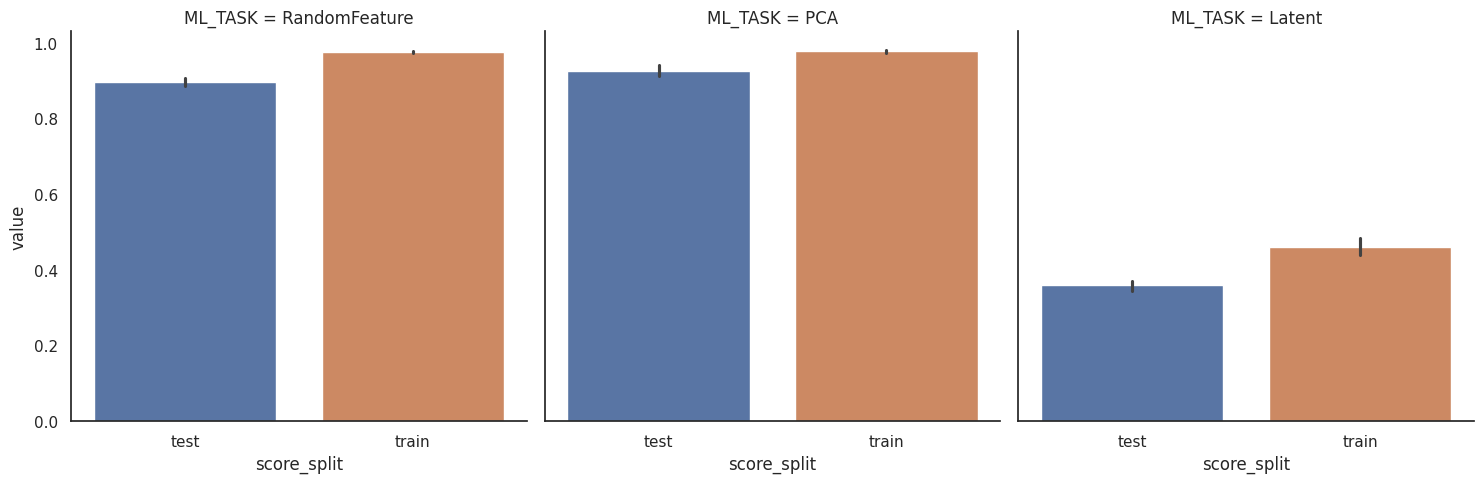

In [30]:
fig_condition_eval_tabpfn = stackix.visualizer.show_evaluation(
	param=my_target_param, # The parameter to visualize
	metric="accuracy", # The metric we specified
	ml_alg=str(tabpfn_class) # The string representation of the classifier used
)

# XModalix specifics

## Embedding evaluation
Since XModalix is composed of multiple VAE for each modality, evaluate behaves slightly different. 
In the case embedding evaluation it will perform evaluation for each VAE (modality) and test its performance for the specified downstream task. 

## Pure VAE comparison
The function `xmodalix.evaluator.pure_vae_comparison()` is designed to evaluate the reconstruction capability of a XModalix (reference and translated) against a normal Imagix on the image target modality. This evaluation provides insights whether the enforced latent space alignment and coupled training in the XModalix decreases or improves the reconstruction capability in comparison to image-only autoencoder. 

The prerequisite for this comparison is the prior training of an imagix. An example is provided in the XModalix tutorial. 
